In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field

In [2]:
load_dotenv()

model = ChatOpenAI(model='gpt-4o-mini')

In [3]:
class SentimentSchema(BaseModel):
    sentiment: Literal['positive', 'negative'] = Field(description='Sentiment of the review')

class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')


In [4]:
structured_model = model.with_structured_output(SentimentSchema)
structured_model2 = model.with_structured_output(DiagnosisSchema)


In [5]:
prompt = 'What is the sentiment of the following review - The software is not too bad.'
structured_model.invoke(prompt)

SentimentSchema(sentiment='positive')

In [6]:
class ReviewState(TypedDict):

    review: str
    sentiment: Literal['positive', 'negative']
    diagnosis: dict
    response: str

In [7]:
def find_sentiment(state: ReviewState):

    prompt = f'For the follwoing review find out the sentiment \n {state["review"]}'
    sentiment = structured_model.invoke(prompt).sentiment

    return {'sentiment': sentiment}


def check_sentiment(state: ReviewState) -> Literal['positive_response', 'run_diagnosis']:

    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'
    

def positive_response(state: ReviewState):

    prompt = f"""Write a warm thank-you message in response to this review:
    \n\n\"{state['review']}\"\n
    Also, kindly ask the user to leave feedback on our website."""

    response = model.invoke(prompt).content

    return response


def run_diagnosis(state: ReviewState):

    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
    """
    response = structured_model2.invoke(prompt)

    return {'diagnosis': response.model_dump()}

def negative_response(state: ReviewState):

    diagnosis = state['diagnosis']

    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    response = model.invoke(prompt).content

    return {'response': response}



In [10]:
graph = StateGraph(ReviewState)

graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_response', negative_response)

graph.add_edge(START, 'find_sentiment')

graph.add_conditional_edges('find_sentiment', check_sentiment)
graph.add_edge('positive_response', END)

graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)

workflow = graph.compile()

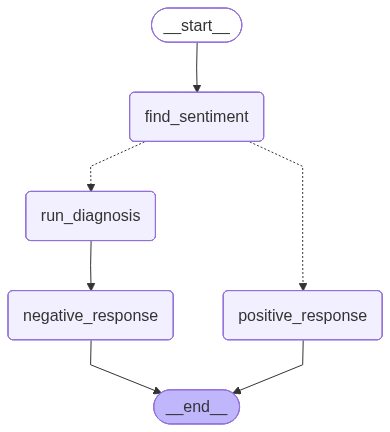

In [11]:
workflow

In [12]:
intial_state={
    'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
workflow.invoke(intial_state)


{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Bug', 'tone': 'frustrated', 'urgency': 'high'},
 'response': "Subject: We're Here to Help!\n\nHi [User's Name],\n\nI truly understand how frustrating it can be to deal with bugs, especially when they disrupt your work. I want to assure you that we’re here to help you resolve this as quickly as possible.\n\nCould you please provide me with a few details about the issue? Specifically, it would be helpful to know what you were doing when the bug occurred, any error messages you received, and the device or software version you’re using. This information will allow us to diagnose the issue more effectively.\n\nYour experience is important to us, and we’re committed to getting this resolved swift